In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
import torch
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report
from pathlib import Path
import seaborn as sns
import random
sys.path.insert(0, '..')
from train_binary_cl import (
    get_args_parser,
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    plot_sample,
    seed_everything,
    seed_worker
)
from util.engine import train_one_epoch_binary_cl as train_one_epoch
from util.engine import evaluate_binary_cl as evaluate
import util.contact_matrix as cm
import datetime
from models.binary_classifier import build as build_model, obtain_predictions_ground_truth, calc_metrics
import util.misc as utils
from util import contact_matrix
from util.plot_utils import obtain_plot, plot_logs
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, DistributedSampler
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')
ufold_dir = os.path.join(ROOT_DIR, 'UFold_dependencies')
ufold_path= os.path.join(ufold_dir, 'models', 'ufold_train_alldata.pt')
bert_pretrained_dir = os.path.join(ROOT_DIR, 'dataset', 'pre_trained_DNABERT', '6-new-12w-0')

parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()
args.output_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl')
args.dataset_path = os.path.join(ROOT_DIR, 'dataset')
args.device = 'cuda:0'

seed_everything(14)

In [4]:
args.batch_size = 32

In [5]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    output_dir = Path(args.output_dir)

if os.path.isfile(os.path.join(args.output_dir, 'checkpoint.pth')):
    args.resume = os.path.join(args.output_dir, 'checkpoint.pth')
    args.resume = args.resume.replace('checkpoint.pth', 'best_model.pth')
    
pos_width_multipliers_val = {3: 0.01, 19: 0.29, 21: 0.7}
pos_height_multipliers_val = pos_width_multipliers_val
neg_width_windows_val = {(50, 100): 0.05, (100, 160): 0.2, 
                         (160, 260): 0.05, (260, 350): 0.2, 
                         (350, 450): 0.25, (450, 511): 0.1, 
                         (511, 512): 0.15}
neg_height_windows_val = neg_width_windows_val
regionspec_multipliers_val = pos_width_multipliers_val
regionspec_windows_val = neg_width_windows_val
assert np.round(sum(pos_width_multipliers_val.values()), 4) == np.round(sum(neg_width_windows_val.values()), 4) == 1    
policies_val = [
        EasyPosAugment(
            per_sample=6,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=regionspec_multipliers_val,
            height_multipliers=regionspec_multipliers_val,
        ),
        EasyNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        HardPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        HardNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        RegionSpecNegAugment(
        per_sample=2,
        width_windows=regionspec_multipliers_val,
        height_windows=neg_height_windows_val,
    ),
]

dataset_val = RNADataset(
        gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
            interactions_path=os.path.join(
                processed_files_dir, "df_annotation_files_cleaned.csv"
            ),
            dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
            subset_file=os.path.join(
                rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"
            ),
        augment_policies=policies_val
)

sampler_val = torch.utils.data.SequentialSampler(dataset_val)

g = torch.Generator()
g.manual_seed(0)
data_loader_test = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

/tmp/ipykernel_29420/4036073190.py:51: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_val = RNADataset(


In [6]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args, bert_pretrained_dir, ufold_path)
model.to(device)
model_without_ddp = model

checkpoint = torch.load(args.resume, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [7]:
start_time = time.time()
model.eval()
criterion.eval()

probability = []
ground_truth = []
g1 = []
g2 = []
policy = []
len_g1 = []
len_g2 = []
couple_id = []

with torch.no_grad():
    for samples, targets in tqdm(data_loader_test):
        
        rna1, rna2 = samples
        rna1[0] = rna1[0].to(device)
        rna2[0] = rna2[0].to(device)
        rna1[1].tensors = rna1[1].tensors.to(device)
        rna2[1].tensors = rna2[1].tensors.to(device)
        rna1[1].mask = rna1[1].mask.to(device)
        rna2[1].mask = rna2[1].mask.to(device)

        outputs = model(rna1, rna2)
        probability += outputs['cnn_output'].softmax(-1)[:, 1].tolist()
        for t in targets:
            ground_truth.append(t['interacting'])
            policy.append(t['policy'])
            couple_id.append(t['couple_id'])
            g1.append(t['gene1'])
            g2.append(t['gene2'])
            len_g1.append(t['bbox'].x2 - t['bbox'].x1)
            len_g2.append(t['bbox'].y2 - t['bbox'].y1)

res = pd.DataFrame({
    'probability':probability,
    'ground_truth':ground_truth,
    'g1':g1,
    'g2':g2,
    'policy':policy,
    'len_g1': len_g1,
    'len_g2': len_g2,
    'couples':couple_id,
})

res['prediction'] = (res['probability'] > 0.5).astype(int)

(res['prediction'] == res['ground_truth']).sum()/res.shape[0]

res['sampled_area'] = res['len_g1']*res['len_g2']

  0%|          | 0/217 [00:00<?, ?it/s]

/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      3494
           1       0.94      0.76      0.84      3424

    accuracy                           0.86      6918
   macro avg       0.87      0.86      0.86      6918
weighted avg       0.87      0.86      0.86      6918



# Plots

### Log plots

In [9]:
df = pd.read_csv(os.path.join(processed_files_dir,"df_annotation_files_cleaned.csv"), sep = ',')
assert df.merge(res, on = 'couples').shape[0] >= res.shape[0]
if df.merge(res, on = 'couples').shape[0] > res.shape[0]:
    print(f"Be careful, some prediction will be counted more than one time. The number of duplicated sequences is {(df.merge(res, on = 'couples').shape[0]-res.shape[0])}")
res = df.merge(res, on = 'couples')

df_info = pd.read_csv(os.path.join(processed_files_dir, "df_cdna.csv"), sep = ',')[['protein_coding','gene_id']].rename({'gene_id':'gene'},axis = 1)

res = res.merge(df_info, left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'protein_coding': 'gene1_pc'}, axis = 1)
res = res.merge(df_info, left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'protein_coding': 'gene2_pc'}, axis = 1)

/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
log = pd.read_json(Path(os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl',  'log.txt')), lines=True)

In [11]:
best_model = np.argmax(log.test_accuracy)

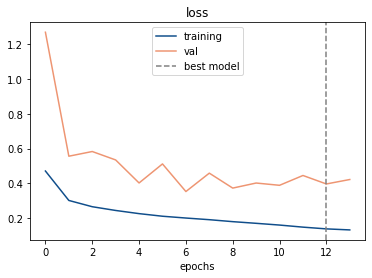

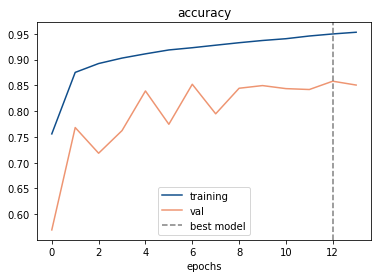

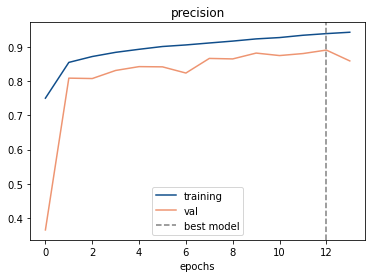

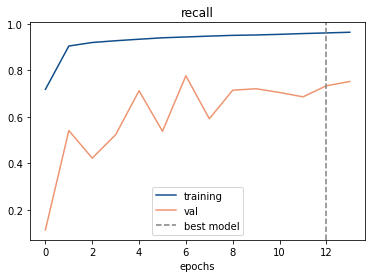

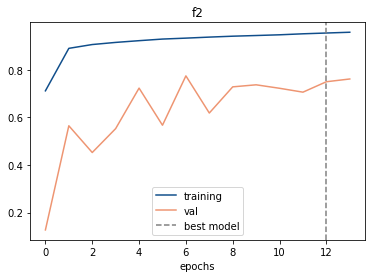

In [12]:
for metric in ['loss', 'accuracy', 'precision', 'recall', 'f2']:
    plot_logs(log, metric, best_model = best_model)

In [13]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    4133
1    2785
Name: prediction, dtype: int64


0    3494
1    3424
Name: ground_truth, dtype: int64


In [14]:
n_conf = 10

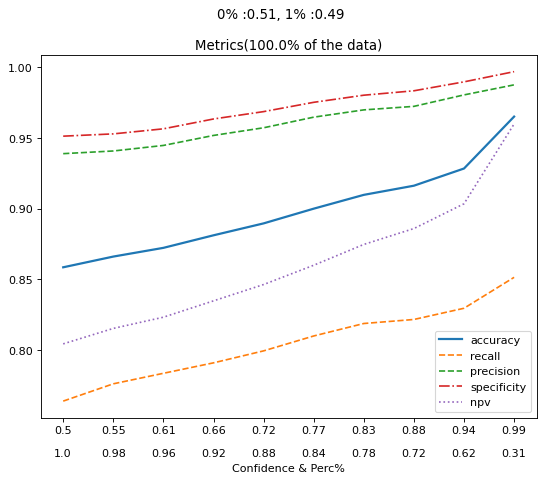

In [15]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

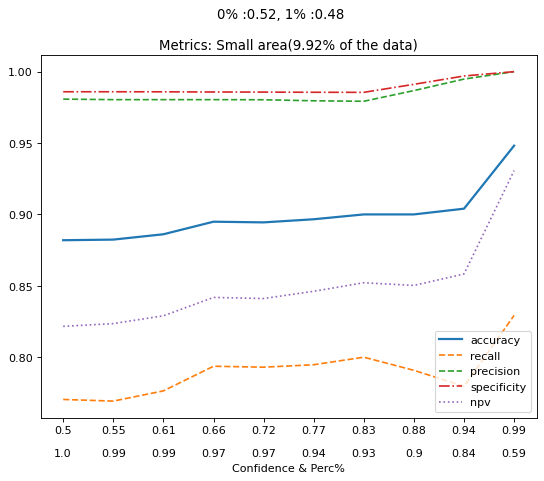

In [16]:
small_areas = res.sampled_area.quantile(0.1)

small_areas = res[res['sampled_area'] < small_areas]

obtain_plot(small_areas, n_original_df = res.shape[0], title = f'Metrics: Small area', n_conf = n_conf)

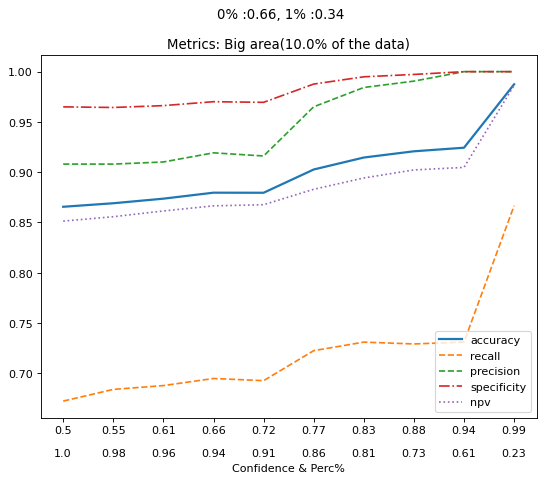

In [17]:
big_area = res.sampled_area.quantile(0.9)

big_area = res[res['sampled_area'] > big_area]

obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

Anziche vedere la grandezza della matrice campionata, vediamola in rapporto alla dimensione della matrice originale, cosi possiamo misurare la "quantita di informazione persa per via del campionamento"

In [18]:
res['area_ratio'] = res['sampled_area']/res['area_of_the_matrix']

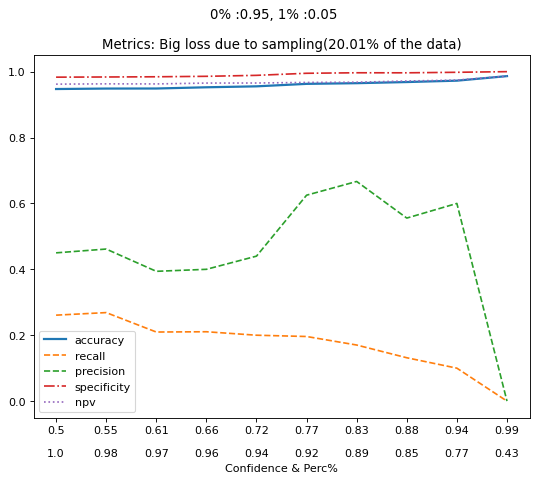

In [19]:
big_loss = res.area_ratio.quantile(0.2)

big_loss = res[res['area_ratio'] < big_loss] 
obtain_plot(big_loss, n_original_df = res.shape[0], title = f'Metrics: Big loss due to sampling', n_conf = n_conf)

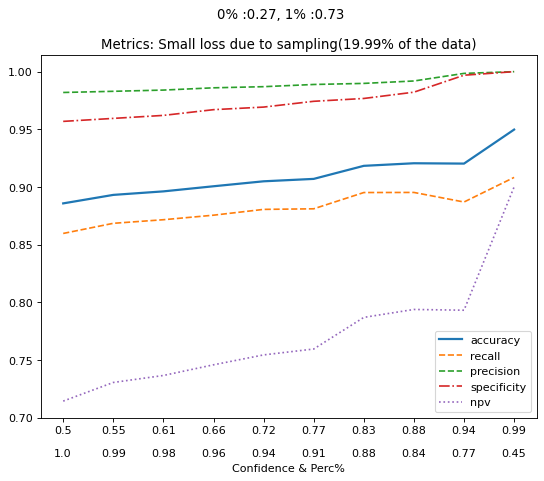

In [20]:
small_loss = res.area_ratio.quantile(0.8)

small_loss = res[res['area_ratio'] > small_loss]

obtain_plot(small_loss, n_original_df = res.shape[0], title = f'Metrics: Small loss due to sampling', n_conf = n_conf)

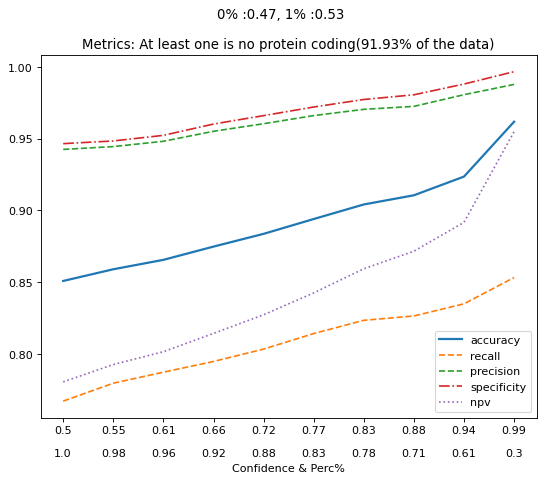

In [21]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

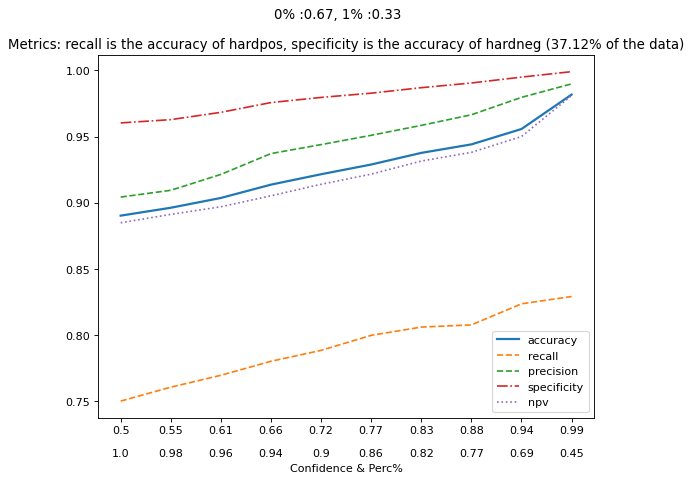

In [22]:
hard = res[(res.policy == 'hardpos')|(res.policy == 'hardneg')]

obtain_plot(hard, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of hardpos, specificity is the accuracy of hardneg ', n_conf = n_conf)

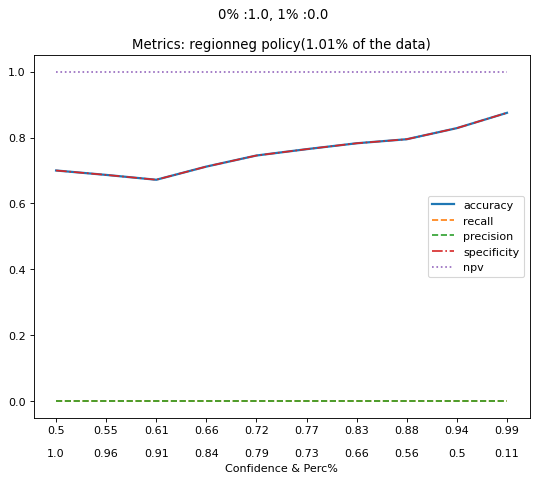

In [23]:
regionneg = res[(res.policy == 'regionneg')]

obtain_plot(regionneg, n_original_df = res.shape[0], title = f'Metrics: regionneg policy', n_conf = n_conf)

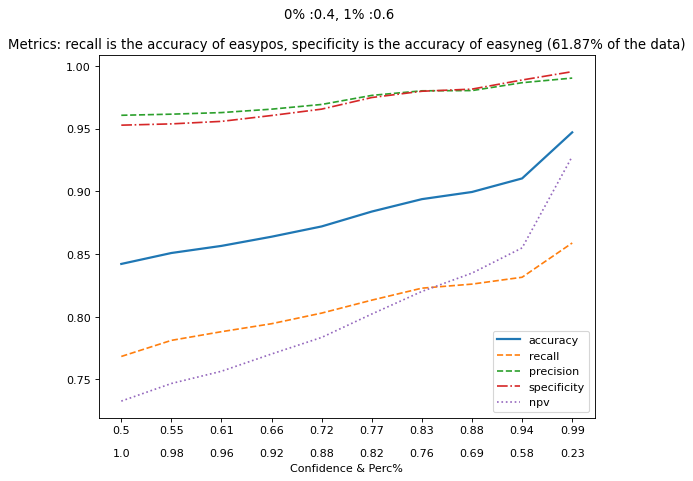

In [24]:
easy = res[(res.policy == 'easypos')|(res.policy == 'easyneg')]

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of easyneg ', n_conf = n_conf)

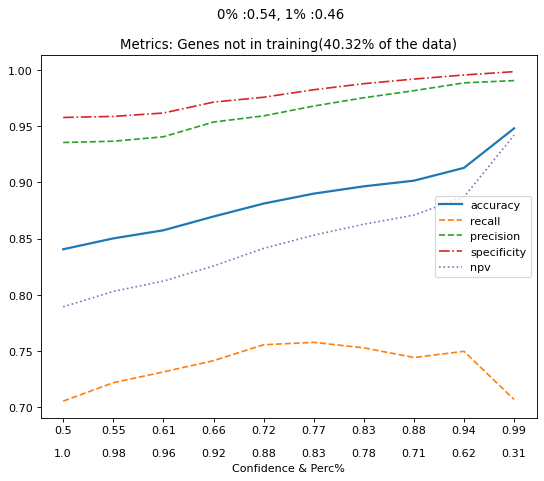

In [25]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_random_filtered.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
df_train = pd.DataFrame({'couples':gene_pairs_train})
df_train['g1'] = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()[0]
df_train['g2'] = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()[1]
df_train_genes = list(set(list(df_train.g1) + list(df_train.g2)))

not_in_train = res[~(res.g1.isin(df_train_genes) | res.g2.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

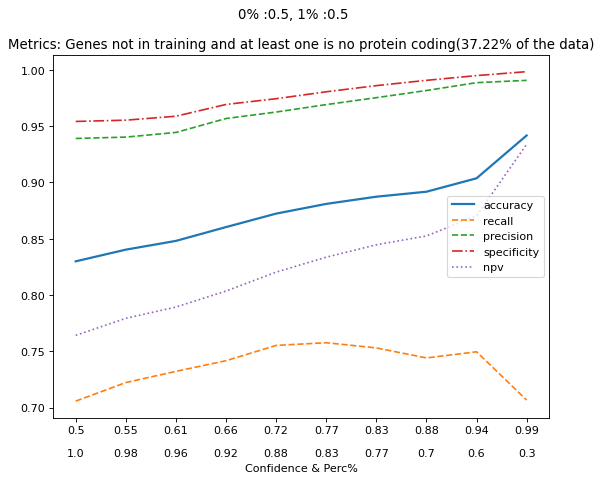

In [26]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = n_conf)

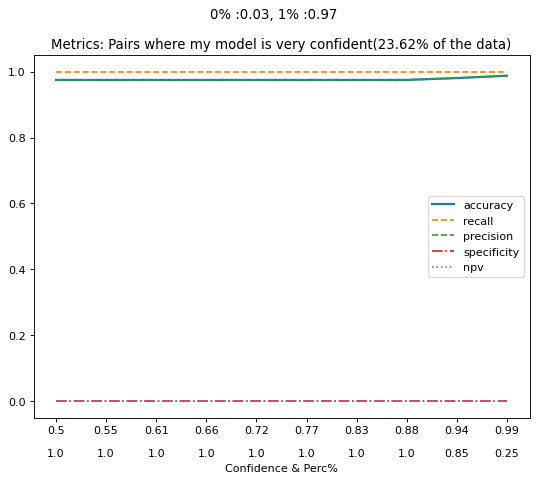

In [27]:
high_prob_pairs = res[res.probability>0.9]


obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: Pairs where my model is very confident', n_conf = n_conf)

# Sequence similarity analysis
Let's now analyze the cluster results

Per la valutazione del clustering, utilizza 2 criteri. Il primo è quello che hai gia implementato. Se il gene 1 del validation sta in un cluster in cui ci sono geni del training, escludo tutte le coppie dove compare il gene 1 dal validation per la stima delle performance. Il secondo metodo di valutazione è meno restrittivo: abbiamo la coppia 1-2 nel validation e la coppia 3-4 nel training. La sequenza 1 sta nel cluster X, la sequenza 2 sta nel cluster Y. Se abbiamo una coppia di geni del training 3-4 in cui ad esempio 4 sta nel cluster X e 3 sta nel cluster Y, allora escludo 1-2 dalla stima delle performance. Se invece 4 sta nel cluster X e 3 sta nel cluster Z, allora 1-2 la posso mettere. Usa questi metodi di valutazione sia per il clustering fatto fino ad ora sia per il clustering full length.

### Slice

In [29]:
cl = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters.csv')) #mmseq2_clusters.csv

Approccio restrittivo

In [30]:
cl_train = cl[cl.couple.isin(gene_pairs_train)].reset_index(drop = True)
val_couples = set(res.couples)
cl_val = cl[cl.couple.isin(val_couples)].reset_index(drop = True)

cluster_train = set(cl_train.cl_name)
cluster_val = set(cl_val.cl_name)
cluster_val_not_in_train = cluster_val - cluster_train
couples_of_val_in_cl_not_in_train_overlapping = set(cl_val[cl_val.cl_name.isin(cluster_val_not_in_train)].couple)

In [31]:
no_pc_no_train_cl = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping)]

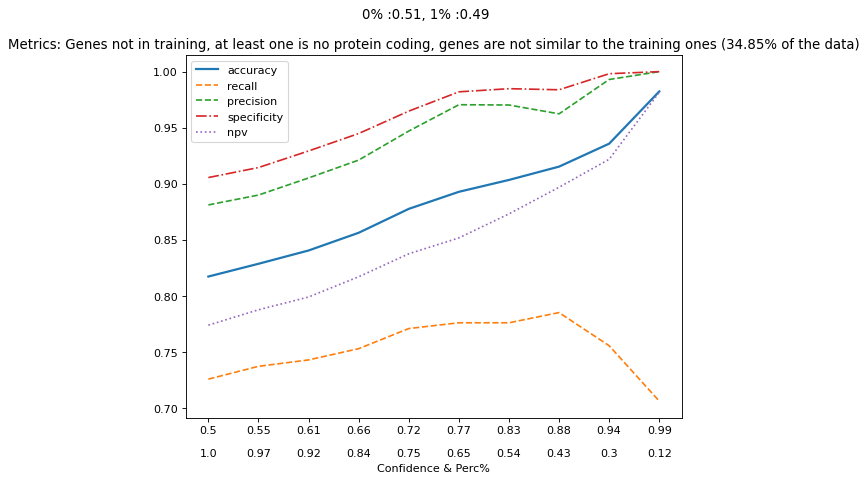

In [32]:
obtain_plot(no_pc_no_train_cl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

In [33]:
no_pc_no_train_cl.prediction.value_counts()

0    1436
1     975
Name: prediction, dtype: int64

Approccio meno restrittivo

La percentuale di coppie che ha un unica combinazione di cluster è il 98.24%


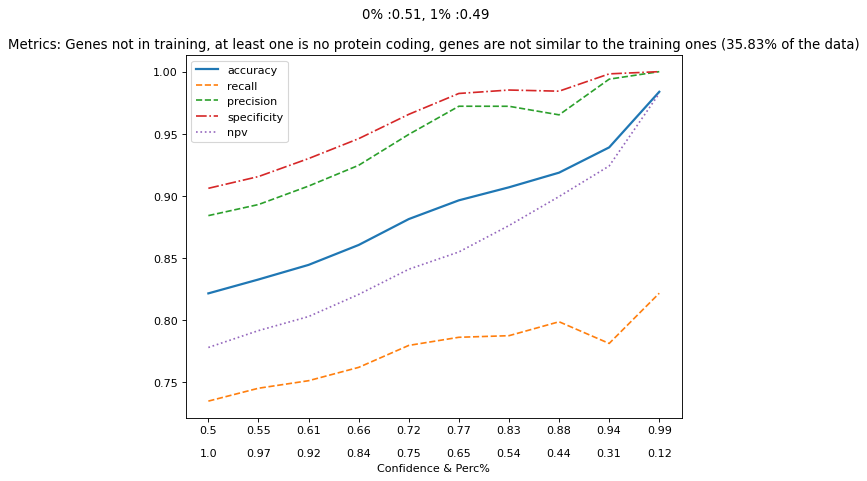

In [34]:
cl_ = cl.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p = np.round((len(cl_.cl_name.unique())/cl_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p}%')

cl_train_ = cl_[cl_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val_ = cl_[cl_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train_ = set(cl_train_.cl_name)
cluster_val_ = set(cl_val_.cl_name)
cluster_val_not_in_train_ = cluster_val_ - cluster_train_
couples_of_val_in_cl_not_in_train_overlapping_ = set(cl_val_[cl_val_.cl_name.isin(cluster_val_not_in_train_)].couple)

no_pc_no_train_cl_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping_)]

obtain_plot(no_pc_no_train_cl_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

### Full length clustering

In [35]:
cl1 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl_merged.csv')) #mmseq2_clusters.csv
cl2 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl2_merged.csv')) #mmseq2_clusters.csv

Cluster 1 - approccio restrittivo

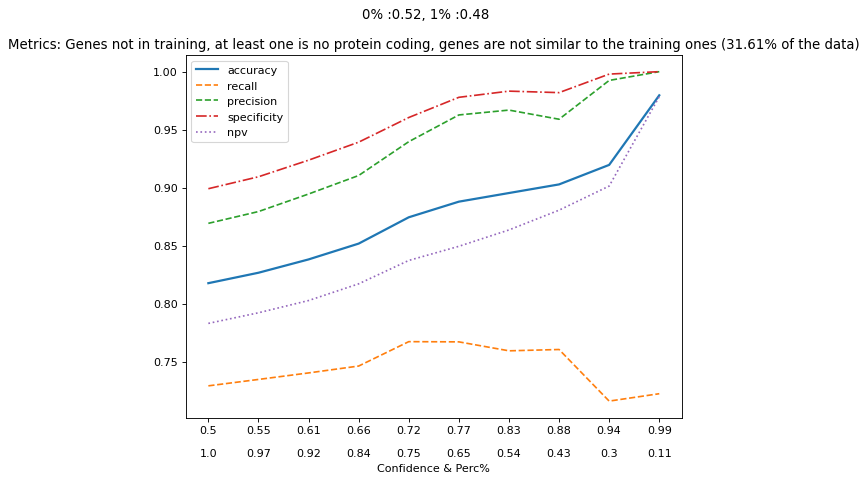

In [36]:
cl_train1 = cl1[cl1.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val1 = cl1[cl1.couple.isin(val_couples)].reset_index(drop = True)

cluster_train1 = set(cl_train1.cl_name)
cluster_val1 = set(cl_val1.cl_name)
cluster_val_not_in_train1 = cluster_val1 - cluster_train1
couples_of_val_in_cl_not_in_train_overlapping1 = set(cl_val1[cl_val1.cl_name.isin(cluster_val_not_in_train1)].couple)

no_pc_no_train_cl1 = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping1)]

obtain_plot(no_pc_no_train_cl1, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 1 - approccio meno restrittivo

In [37]:
cl1_ = cl1.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p1 = np.round((len(cl1_.cl_name.unique())/cl1_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p1}%')

La percentuale di coppie che ha un unica combinazione di cluster è il 97.88%


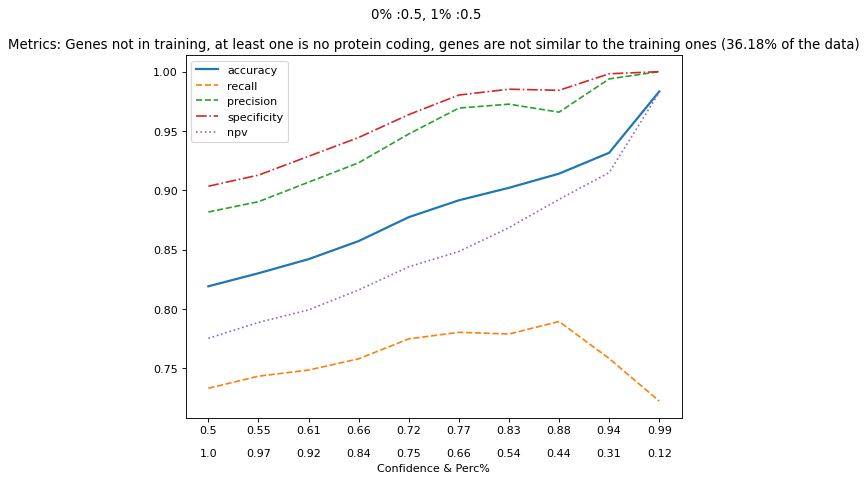

In [38]:
cl_train1_ = cl1_[cl1_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val1_ = cl1_[cl1_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train1_ = set(cl_train1_.cl_name)
cluster_val1_ = set(cl_val1_.cl_name)
cluster_val_not_in_train1_ = cluster_val1_ - cluster_train1_
couples_of_val_in_cl_not_in_train_overlapping1_ = set(cl_val1_[cl_val1_.cl_name.isin(cluster_val_not_in_train1_)].couple)

no_pc_no_train_cl1_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping1_)]

obtain_plot(no_pc_no_train_cl1_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 2 - approccio restrittivo

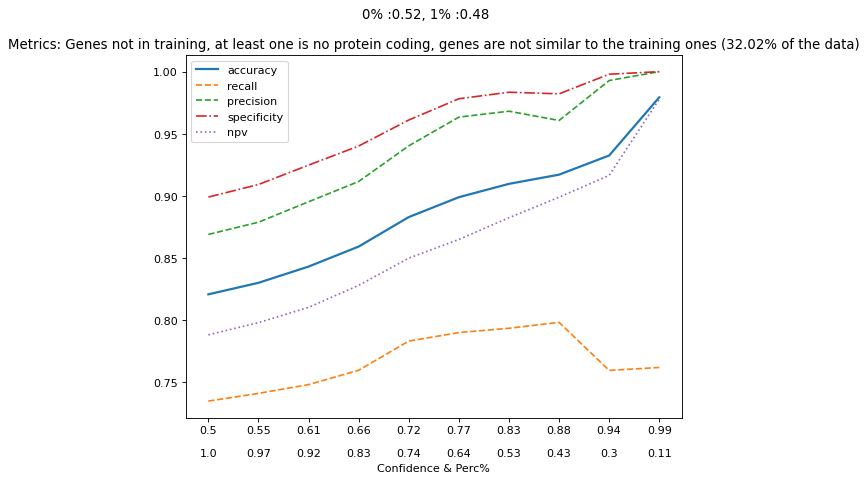

In [39]:
cl_train2 = cl2[cl2.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val2 = cl2[cl2.couple.isin(val_couples)].reset_index(drop = True)

cluster_train2 = set(cl_train2.cl_name)
cluster_val2 = set(cl_val2.cl_name)
cluster_val_not_in_train2 = cluster_val2 - cluster_train2
couples_of_val_in_cl_not_in_train_overlapping2 = set(cl_val2[cl_val2.cl_name.isin(cluster_val_not_in_train2)].couple)

no_pc_no_train_cl2 = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping2)]

obtain_plot(no_pc_no_train_cl2, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

Cluster 1 - approccio meno restrittivo

La percentuale di coppie che ha un unica combinazione di cluster è il 98.04%


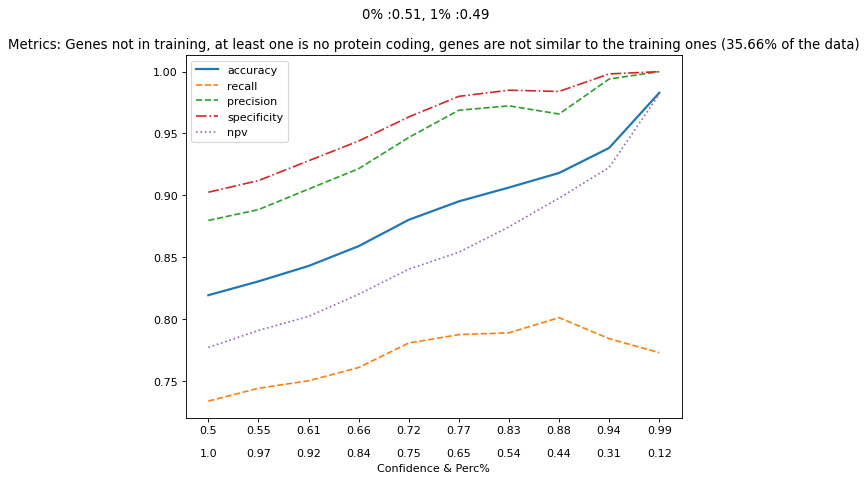

In [40]:
cl2_ = cl2.sort_values('cl_name', ascending = True).groupby('couple')['cl_name'].apply(list).apply(str).reset_index(name='cl_name')

p2 = np.round((len(cl2_.cl_name.unique())/cl2_.shape[0])*100, 2)
print(f'La percentuale di coppie che ha un unica combinazione di cluster è il {p2}%')

cl_train2_ = cl2_[cl2_.couple.isin(gene_pairs_train)].reset_index(drop = True)
cl_val2_ = cl2_[cl2_.couple.isin(val_couples)].reset_index(drop = True)

cluster_train2_ = set(cl_train2_.cl_name)
cluster_val2_ = set(cl_val2_.cl_name)
cluster_val_not_in_train2_ = cluster_val2_ - cluster_train2_
couples_of_val_in_cl_not_in_train_overlapping2_ = set(cl_val2_[cl_val2_.cl_name.isin(cluster_val_not_in_train2_)].couple)

no_pc_no_train_cl2_ = no_pc_no_train[no_pc_no_train.couples.isin(couples_of_val_in_cl_not_in_train_overlapping2_)]

obtain_plot(no_pc_no_train_cl2_, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)

I am evaluating 15 sequences


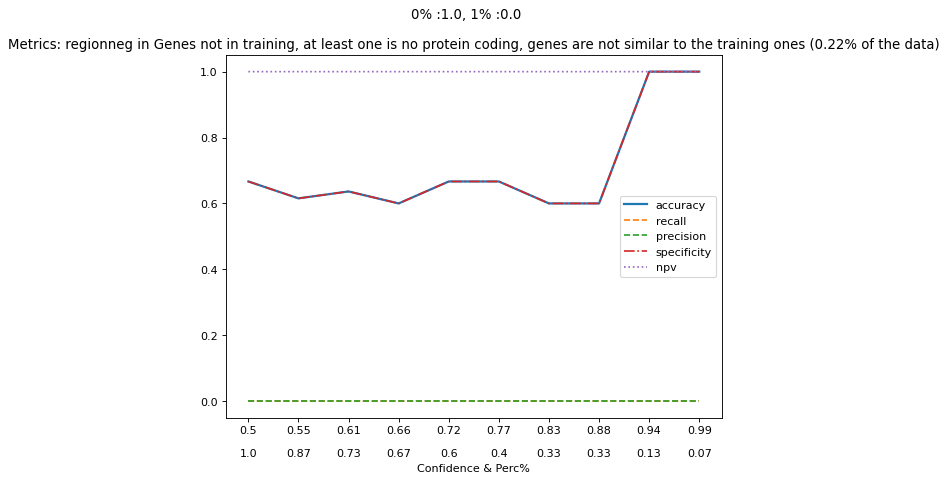

In [41]:
no_pc_no_train_cl2_regionneg = no_pc_no_train_cl2_[no_pc_no_train_cl2_.policy == 'regionneg']
print(f'I am evaluating {no_pc_no_train_cl2_regionneg.shape[0]} sequences')
obtain_plot(no_pc_no_train_cl2_regionneg, n_original_df = res.shape[0], title = f'Metrics: regionneg in Genes not in training, at least one is no protein coding, genes are not similar to the training ones ', n_conf = n_conf)